In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from functools import partial
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO

import bayesreg_pyro as br
import vi_diagnostics as vid

In [5]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()

y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [73]:
# these should be common for all models ran
model = br.BayesianRegression(in_features, 1)
optimser = pyro.optim.Adam({"lr": 0.009})

In [ ]:
guide_adn = AutoDiagonalNormal(model) # Stochastic Mean field
svi_adn = SVI(model, guide_adn, optimser, loss=Trace_ELBO())

torch.manual_seed(12)
pyro.clear_param_store()
tic = time.time()
elbos = model.run_vi(x_data, y_data, svi_adn, model)
toc = time.time()
print(f"SVI time: {toc-tic} sec")
guide_adn.requires_grad_(False)
samples, iw = br.sample_and_calculate_log_impweight(x_data, y_data, model, guide_adn, num_post_samples=int(1e3))

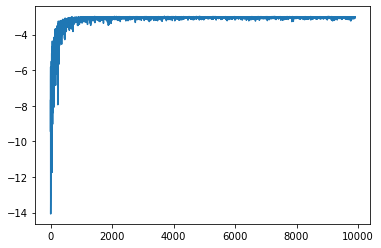

In [9]:
plt.plot(elbos[100:])

In [12]:
pyro.param("AutoDiagonalNormal.loc")

Parameter containing:
tensor([ 1.4658,  0.0525, -0.0924, -0.0865, -0.4747, -0.0157,  0.9552, -0.1986,
         0.2417,  0.0040,  0.1335,  0.1840,  0.4318, -1.2441, -0.0490])

In [12]:
#pyro.param("AutoDiagonalNormal.loc")

In [94]:
pyro.set_rng_seed(20201101)
# prefer a new guide to re-infer multiple times so the actual posterior is kept from overwriting 
tic = time.time()
prob, kapp = vid.diagnose_vi_VSBC(
    x_data, model, guide_class=AutoDiagonalNormal, replications=2, vi_num_iterations=3000,
    adjust_VI_method=None,
)
toc = time.time()

.--

In [95]:
kapp

tensor([5.7775, 4.3488])

In [96]:
with open("results/AutoDiagonalNormal_None_20201101_1_3000.pkl", "rb") as f:
    res=pickle.load(f)
print(res)

(array([[3.2174855e-02, 3.2588404e-01, 6.8545341e-07, 9.9874169e-01,
        1.0000000e+00, 1.6484490e-01, 9.9999595e-01, 9.7284096e-01,
        9.9999583e-01, 0.0000000e+00, 9.9999917e-01, 3.7747785e-01,
        2.3691005e-01, 6.6538811e-02, 7.5648481e-01]], dtype=float32), tensor([5.7775]))


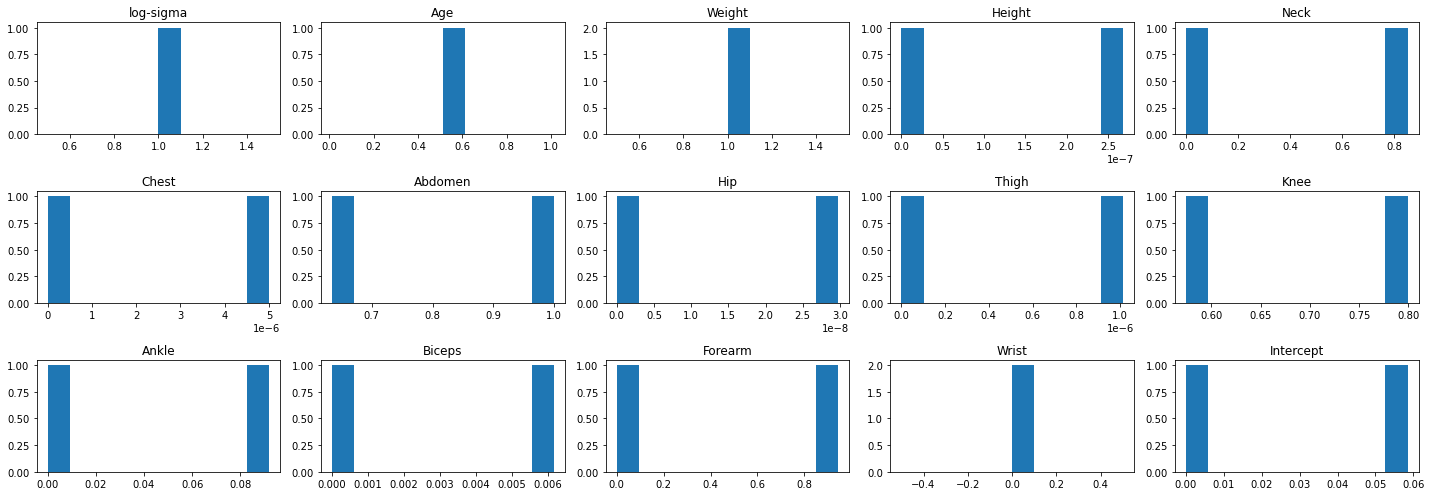

In [35]:
df=pd.DataFrame(prob)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 7))
colnames = ["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]

for i, ax in enumerate(axes.reshape(-1)):
    col = df.columns[i]
    ax.hist(df[col])
    ax.set_title(colnames[i])

plt.tight_layout()
plt.show()

In [30]:
pyro.param("AutoDiagonalNormal.loc")

Parameter containing:
tensor([ 0.9202, -0.3436, -0.7350,  0.5798, -1.5790, -0.7055,  0.7853, -0.2453,
        -0.1232,  0.7973, -0.1584, -1.2304, -0.0561, -0.0558, -1.5370])

In [73]:
# need to run the same for the mvt model:
torch.manual_seed(12)
pyro.clear_param_store()

guide_mvt = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi_mvt = SVI(model, guide_mvt, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

tic = time.time()
elbos_mvt, samples_mvt = br.run_vi(x_data, y_data, svi_mvt, model, guide_mvt)
toc=time.time()
print(f"Non-MFVI time: {toc-tic} sec")

Non-MFVI time: 23.26911187171936 sec


In [82]:
inf_engine_mvt = partial(
    br.run_vi, vi_engine=svi_mvt, model=model, guide=guide_mvt, num_iterations=5000, return_elbo=False
)
torch.manual_seed(1212)
tic = time.time()
prob_mvt = vid.diagnose_vi_VSBC(x_data, model, guide_mvt, inf_engine_mvt, replications=150)
toc = time.time()


...............

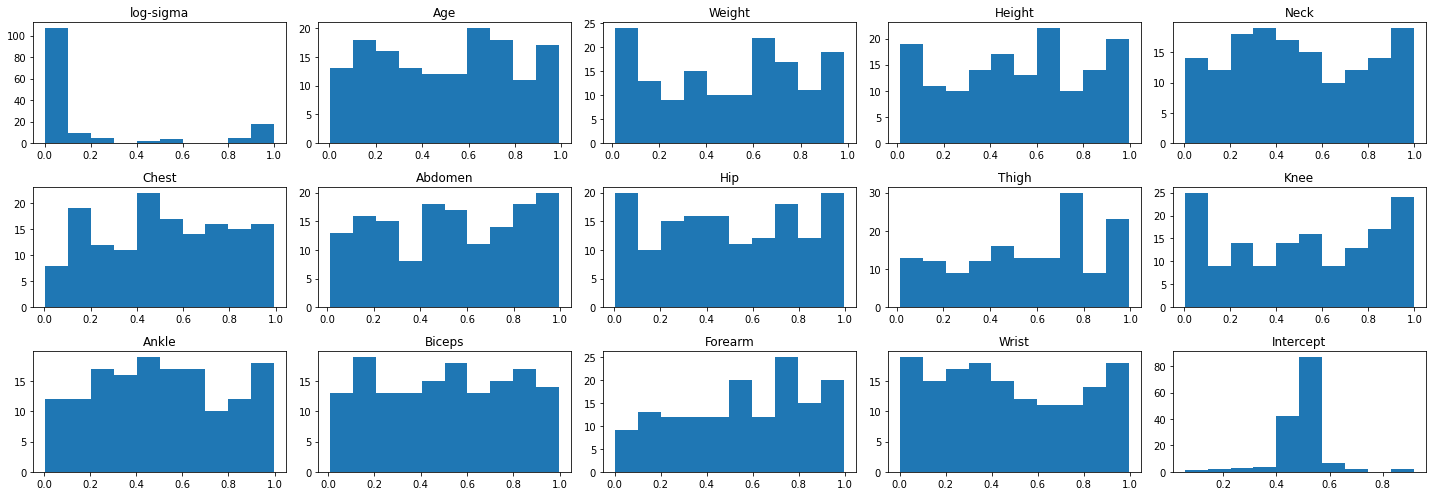

In [88]:
df=pd.DataFrame(prob_mvt)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 7))
colnames = ["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]

for i, ax in enumerate(axes.reshape(-1)):
    col = df.columns[i]
    ax.hist(df[col], bins=10)
    ax.set_title(colnames[i])

plt.tight_layout()
plt.show()

In [84]:
pd.DataFrame(prob).to_csv("prob_MFVI.csv")
pd.DataFrame(prob_mvt).to_csv("prob_MVG_VI.csv")